In [7]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
torch.set_default_dtype(torch.float64)

In [8]:
def f(x, y, z, w):
    return -x**4+200*x+y**4-200*y-z**4+200*z-w**4+200*w

num_of_samples = 10
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))
z_data = np.float64(np.linspace(-5, 5, num_of_samples))
w_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y, Z, W = np.meshgrid(x_data, y_data, z_data, w_data)
outs = f(X, Y, Z, W)

In [9]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1), W.reshape(-1, 1)), axis=1), outs.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

activation = nn.Sigmoid()

In [10]:
model = ELM(4, 100, 1).to(device)

In [11]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T.to(device))
H = torch.concatenate([torch.ones(1, len(trainset)).to(device), V.to(device)], dim=0).T
T = trainset[:][1].reshape(1, -1).T.to(device)
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

Train error: 39523.99307867743
Test error: 40529.521010219054


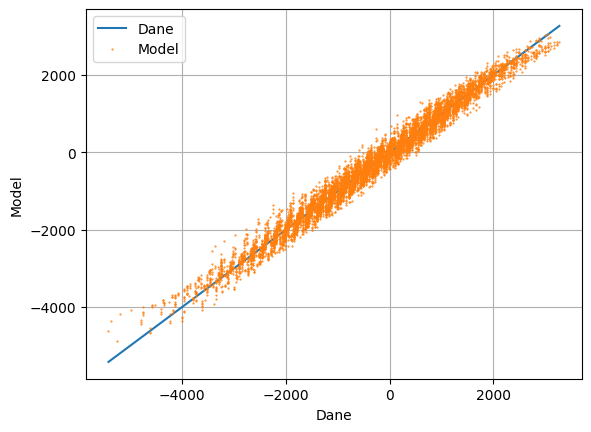

In [12]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4).to(device))-trainset[:][1].reshape(-1, 1).to(device)).cpu().reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4).to(device))-testset[:][1].reshape(-1, 1).to(device)).cpu().reshape(-1).pow(2).mean()}')
plt.plot([np.min(outs), np.max(outs)], [np.min(outs), np.max(outs)])
plt.plot(outs.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1), torch.Tensor(Z).reshape(-1, 1), torch.Tensor(W).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1), '.', markersize=1)
plt.legend(['Dane', 'Model'], loc='upper left')
plt.xlabel('Dane')
plt.ylabel('Model')
plt.grid()
plt.show()